In [1]:
from training.run import Run
from evaluation import metrics, plots

In [2]:
def make_config(model_name):
    return {'model_name': model_name, 'features': 'all', 'train_size': 40, 
                  'test_size': 20, 'pca': 2, 'dataset': 'breast_cancer', 'seed': 10598}

In [3]:
def test(config):
    run = Run(config)
    metrics.print_metrics(run)
    plots.plot_roc_curve(run)
    plots.plot_scores(run)

## Scikit-learn SVM

In [4]:
config = make_config('sklearn_svm')

Printing metrics for run at /home/alex/qsvm_jet_tagging/results/012.
	Testing accuracy = 1.0
	support = 5/40
	Training accuracy = 0.975
	Training time = 1.9972763061523438
	Testing time = 0.0005240440368652344


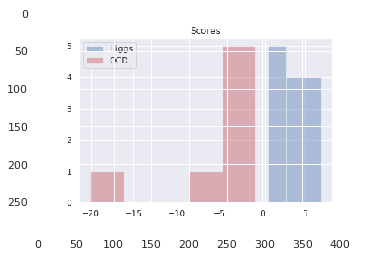

In [5]:
test(config)

## Qiskit Classical SVM

In [6]:
config = make_config('svm_classical')

Printing metrics for run at /home/alex/qsvm_jet_tagging/results/013.
	Testing accuracy = 0.85
	support = 10/40
	Training accuracy = 0.875
	Training time = 0.01935410499572754
	Testing time = 0.0010266304016113281


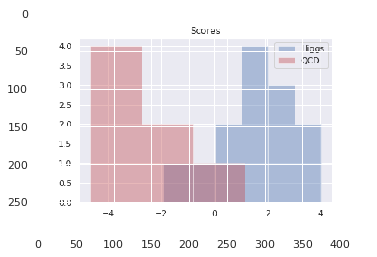

In [7]:
test(config)

## Qiskit QSVM Kernel

In [8]:
config = make_config('qsvm_kernel')

Printing metrics for run at /home/alex/qsvm_jet_tagging/results/025.
	Testing accuracy = 0.85
	support = 38/40
	Training accuracy = 0.825
	Training time = 24.982024431228638
	Testing time = 23.67112374305725


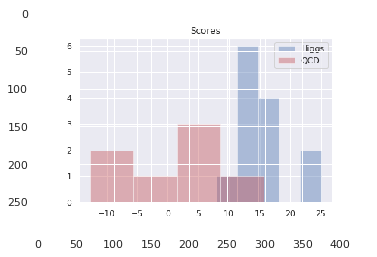

In [9]:
test(config)

## Qiskit QSVM Variational

In [10]:
config = make_config('qsvm_variational')

Printing metrics for run at /home/alex/qsvm_jet_tagging/results/015.
	Testing accuracy = 0.85
	Training accuracy = 0.825
	Training time = 181.97771191596985
	Testing time = 0.6443233489990234


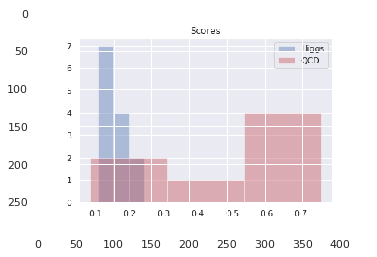

In [11]:
test(config)

# Tutorial

In [12]:
import numpy as np
import scipy
from scipy.linalg import expm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from qiskit_aqua.algorithms import QSVMKernel
from qiskit_aqua.components.feature_maps import SecondOrderExpansion
from qiskit import Aer
from qiskit_aqua import QuantumInstance

In [13]:
seed = 10598

In [14]:
def Breast_cancer(training_size, test_size, n, PLOT_DATA):
    class_labels = [r'A', r'B']
    data, target = datasets.load_breast_cancer(True)
    sample_train, sample_test, label_train, label_test = train_test_split(data, target, test_size=test_size, train_size=training_size, random_state=seed, stratify=target)

    # Now we standarize for gaussian around 0 with unit variance
    std_scale = StandardScaler().fit(sample_train)
    sample_train = std_scale.transform(sample_train)
    sample_test = std_scale.transform(sample_test)

    # Now reduce number of features to number of qubits
    pca = PCA(n_components=n, random_state=seed).fit(sample_train)
    sample_train = pca.transform(sample_train)
    sample_test = pca.transform(sample_test)

    # Scale to the range (-1,+1)
    # NOTE: Modified from tutorial to fit based on train data only.
    minmax_scale = MinMaxScaler((-1, 1)).fit(sample_train)
    sample_train = minmax_scale.transform(sample_train)
    sample_test = minmax_scale.transform(sample_test)
    
    training_input = {key: sample_train[label_train == k] for k, key in enumerate(class_labels)}
    test_input = {key: sample_test[label_test == k] for k, key in enumerate(class_labels)}
    if PLOT_DATA:
        for k in range(0, 2):
            plt.scatter(sample_train[label_train == k, 0],
                        sample_train[label_train == k, 1])

        plt.title("PCA dim. reduced Breast cancer dataset")
        plt.show()

    return sample_test, label_test, training_input, test_input, class_labels

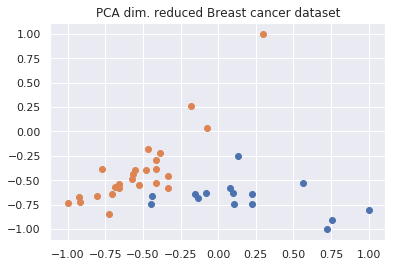

training
	 [[-0.08197567 -0.63194861]
 [ 0.10115308 -0.63376243]
 [ 0.0809197  -0.58023271]
 [ 0.56628705 -0.53213534]
 [-0.1556118  -0.64094847]
 [ 0.10425302 -0.74232997]
 [ 0.22305525 -0.63633412]
 [ 0.7235702  -1.        ]
 [ 0.13156179 -0.2559738 ]
 [ 0.22389231 -0.74808897]
 [ 1.         -0.80925886]
 [-0.44876056 -0.74202742]
 [-0.4377388  -0.66526923]
 [-0.13497233 -0.68007733]
 [ 0.75860767 -0.90559822]]
	 [[-0.80324282 -0.66453074]
 [-0.77114786 -0.37964931]
 [-0.46595027 -0.17793617]
 [-0.33042771 -0.45856439]
 [-0.70253376 -0.64571749]
 [-0.38664067 -0.21979216]
 [-0.91582162 -0.72582301]
 [-0.55196921 -0.39307878]
 [-0.18136485  0.2626561 ]
 [-0.65609878 -0.581317  ]
 [-0.56803806 -0.43821759]
 [-0.66207293 -0.53928075]
 [-0.52817314 -0.5526049 ]
 [-0.6827594  -0.573944  ]
 [-0.5698349  -0.48723819]
 [-0.3346855  -0.58157575]
 [-0.47892123 -0.39905592]
 [-0.72882537 -0.8422467 ]
 [-1.         -0.73668513]
 [ 0.29817008  1.        ]
 [-0.07586854  0.03946071]
 [-0.40978365 

In [15]:
sample_test, label_test, training_input, test_input, class_labels = Breast_cancer(training_size=40,
                                                                       test_size=20,
                                                                       n=2,
                                                                       PLOT_DATA=True)

In [16]:
feature_map = SecondOrderExpansion(num_qubits=2, depth=2, entanglement='linear')
qsvm = QSVMKernel(feature_map, training_input, test_input)

backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed=seed, seed_mapper=seed)

result = qsvm.run(quantum_instance)
print(f'testing size: {len(test_input["A"])+len(test_input["B"])}')
print("testing success ratio: ", result['testing_accuracy'])
      

testing size: 20
testing success ratio:  0.8


In [17]:
from sklearn.utils import shuffle

In [65]:
def predict(X, y, seed):
    index = np.arange(y.shape[0])
    X, y, index = shuffle(X, y, index, random_state=seed)
    y_hat = qsvm.predict(X)
    m = index.argsort()
    X = X[m]
    y = y[m]
    y_hat = y_hat[m]
    print('predict:')
    print('\t X:')
    print(X)
    print('\t y:')
    print(y_hat)
    print('\t y_expected:')
    print(y)
    print('testing_accuracy: ', np.sum(y_hat==y)/y_hat.shape[0])
    

In [66]:
predict(sample_test, label_test, seed=10598)

predict:
	 X:
[[-0.79785325 -0.596832  ]
 [-0.40589212 -0.49802939]
 [-0.87923229 -0.62233004]
 [-0.33376072 -0.68603366]
 [-0.64181417 -0.67902307]
 [-0.59945354 -0.59236367]
 [-0.4483323  -0.43329109]
 [-0.59609731 -0.5375037 ]
 [ 0.01626329 -0.77182174]
 [-0.55292781 -0.69543489]
 [-0.77625395 -0.46040095]
 [-0.86031117 -0.46872192]
 [-0.84130492 -0.52492474]
 [-0.02916742 -0.3295579 ]
 [ 0.1999238  -0.37738835]
 [-0.53509116 -0.40201803]
 [-0.45196765 -0.88445033]
 [ 0.85471618 -1.17005751]
 [-0.40228326 -0.7214732 ]
 [-0.82968685 -0.76651487]]
	 y:
[1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 0 1 1]
	 y_expected:
[1 1 1 0 1 1 1 1 0 1 1 1 1 0 0 1 0 0 0 1]
testing_accuracy:  0.85


In [67]:
predict(sample_test, label_test, seed=53)

predict:
	 X:
[[-0.79785325 -0.596832  ]
 [-0.40589212 -0.49802939]
 [-0.87923229 -0.62233004]
 [-0.33376072 -0.68603366]
 [-0.64181417 -0.67902307]
 [-0.59945354 -0.59236367]
 [-0.4483323  -0.43329109]
 [-0.59609731 -0.5375037 ]
 [ 0.01626329 -0.77182174]
 [-0.55292781 -0.69543489]
 [-0.77625395 -0.46040095]
 [-0.86031117 -0.46872192]
 [-0.84130492 -0.52492474]
 [-0.02916742 -0.3295579 ]
 [ 0.1999238  -0.37738835]
 [-0.53509116 -0.40201803]
 [-0.45196765 -0.88445033]
 [ 0.85471618 -1.17005751]
 [-0.40228326 -0.7214732 ]
 [-0.82968685 -0.76651487]]
	 y:
[1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1]
	 y_expected:
[1 1 1 0 1 1 1 1 0 1 1 1 1 0 0 1 0 0 0 1]
testing_accuracy:  0.8


In [68]:
predict(sample_test, label_test, seed=28347)

predict:
	 X:
[[-0.79785325 -0.596832  ]
 [-0.40589212 -0.49802939]
 [-0.87923229 -0.62233004]
 [-0.33376072 -0.68603366]
 [-0.64181417 -0.67902307]
 [-0.59945354 -0.59236367]
 [-0.4483323  -0.43329109]
 [-0.59609731 -0.5375037 ]
 [ 0.01626329 -0.77182174]
 [-0.55292781 -0.69543489]
 [-0.77625395 -0.46040095]
 [-0.86031117 -0.46872192]
 [-0.84130492 -0.52492474]
 [-0.02916742 -0.3295579 ]
 [ 0.1999238  -0.37738835]
 [-0.53509116 -0.40201803]
 [-0.45196765 -0.88445033]
 [ 0.85471618 -1.17005751]
 [-0.40228326 -0.7214732 ]
 [-0.82968685 -0.76651487]]
	 y:
[1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 0 1 1]
	 y_expected:
[1 1 1 0 1 1 1 1 0 1 1 1 1 0 0 1 0 0 0 1]
testing_accuracy:  0.85


In [69]:
predict(sample_test, label_test, seed=153)

predict:
	 X:
[[-0.79785325 -0.596832  ]
 [-0.40589212 -0.49802939]
 [-0.87923229 -0.62233004]
 [-0.33376072 -0.68603366]
 [-0.64181417 -0.67902307]
 [-0.59945354 -0.59236367]
 [-0.4483323  -0.43329109]
 [-0.59609731 -0.5375037 ]
 [ 0.01626329 -0.77182174]
 [-0.55292781 -0.69543489]
 [-0.77625395 -0.46040095]
 [-0.86031117 -0.46872192]
 [-0.84130492 -0.52492474]
 [-0.02916742 -0.3295579 ]
 [ 0.1999238  -0.37738835]
 [-0.53509116 -0.40201803]
 [-0.45196765 -0.88445033]
 [ 0.85471618 -1.17005751]
 [-0.40228326 -0.7214732 ]
 [-0.82968685 -0.76651487]]
	 y:
[1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 0 1 1]
	 y_expected:
[1 1 1 0 1 1 1 1 0 1 1 1 1 0 0 1 0 0 0 1]
testing_accuracy:  0.85


In [70]:
predict(sample_test, label_test, seed=100)

predict:
	 X:
[[-0.79785325 -0.596832  ]
 [-0.40589212 -0.49802939]
 [-0.87923229 -0.62233004]
 [-0.33376072 -0.68603366]
 [-0.64181417 -0.67902307]
 [-0.59945354 -0.59236367]
 [-0.4483323  -0.43329109]
 [-0.59609731 -0.5375037 ]
 [ 0.01626329 -0.77182174]
 [-0.55292781 -0.69543489]
 [-0.77625395 -0.46040095]
 [-0.86031117 -0.46872192]
 [-0.84130492 -0.52492474]
 [-0.02916742 -0.3295579 ]
 [ 0.1999238  -0.37738835]
 [-0.53509116 -0.40201803]
 [-0.45196765 -0.88445033]
 [ 0.85471618 -1.17005751]
 [-0.40228326 -0.7214732 ]
 [-0.82968685 -0.76651487]]
	 y:
[1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 0 1 1]
	 y_expected:
[1 1 1 0 1 1 1 1 0 1 1 1 1 0 0 1 0 0 0 1]
testing_accuracy:  0.85


In [71]:
predict(sample_test, label_test, seed=0)

predict:
	 X:
[[-0.79785325 -0.596832  ]
 [-0.40589212 -0.49802939]
 [-0.87923229 -0.62233004]
 [-0.33376072 -0.68603366]
 [-0.64181417 -0.67902307]
 [-0.59945354 -0.59236367]
 [-0.4483323  -0.43329109]
 [-0.59609731 -0.5375037 ]
 [ 0.01626329 -0.77182174]
 [-0.55292781 -0.69543489]
 [-0.77625395 -0.46040095]
 [-0.86031117 -0.46872192]
 [-0.84130492 -0.52492474]
 [-0.02916742 -0.3295579 ]
 [ 0.1999238  -0.37738835]
 [-0.53509116 -0.40201803]
 [-0.45196765 -0.88445033]
 [ 0.85471618 -1.17005751]
 [-0.40228326 -0.7214732 ]
 [-0.82968685 -0.76651487]]
	 y:
[1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 0 1 1]
	 y_expected:
[1 1 1 0 1 1 1 1 0 1 1 1 1 0 0 1 0 0 0 1]
testing_accuracy:  0.85


In [72]:
predict(sample_test, label_test, seed=1)

predict:
	 X:
[[-0.79785325 -0.596832  ]
 [-0.40589212 -0.49802939]
 [-0.87923229 -0.62233004]
 [-0.33376072 -0.68603366]
 [-0.64181417 -0.67902307]
 [-0.59945354 -0.59236367]
 [-0.4483323  -0.43329109]
 [-0.59609731 -0.5375037 ]
 [ 0.01626329 -0.77182174]
 [-0.55292781 -0.69543489]
 [-0.77625395 -0.46040095]
 [-0.86031117 -0.46872192]
 [-0.84130492 -0.52492474]
 [-0.02916742 -0.3295579 ]
 [ 0.1999238  -0.37738835]
 [-0.53509116 -0.40201803]
 [-0.45196765 -0.88445033]
 [ 0.85471618 -1.17005751]
 [-0.40228326 -0.7214732 ]
 [-0.82968685 -0.76651487]]
	 y:
[1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 0 1 1]
	 y_expected:
[1 1 1 0 1 1 1 1 0 1 1 1 1 0 0 1 0 0 0 1]
testing_accuracy:  0.85


In [73]:
predict(sample_test, label_test, seed=2)

predict:
	 X:
[[-0.79785325 -0.596832  ]
 [-0.40589212 -0.49802939]
 [-0.87923229 -0.62233004]
 [-0.33376072 -0.68603366]
 [-0.64181417 -0.67902307]
 [-0.59945354 -0.59236367]
 [-0.4483323  -0.43329109]
 [-0.59609731 -0.5375037 ]
 [ 0.01626329 -0.77182174]
 [-0.55292781 -0.69543489]
 [-0.77625395 -0.46040095]
 [-0.86031117 -0.46872192]
 [-0.84130492 -0.52492474]
 [-0.02916742 -0.3295579 ]
 [ 0.1999238  -0.37738835]
 [-0.53509116 -0.40201803]
 [-0.45196765 -0.88445033]
 [ 0.85471618 -1.17005751]
 [-0.40228326 -0.7214732 ]
 [-0.82968685 -0.76651487]]
	 y:
[1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1]
	 y_expected:
[1 1 1 0 1 1 1 1 0 1 1 1 1 0 0 1 0 0 0 1]
testing_accuracy:  0.8


In [74]:
predict(sample_test, label_test, seed=53)

predict:
	 X:
[[-0.79785325 -0.596832  ]
 [-0.40589212 -0.49802939]
 [-0.87923229 -0.62233004]
 [-0.33376072 -0.68603366]
 [-0.64181417 -0.67902307]
 [-0.59945354 -0.59236367]
 [-0.4483323  -0.43329109]
 [-0.59609731 -0.5375037 ]
 [ 0.01626329 -0.77182174]
 [-0.55292781 -0.69543489]
 [-0.77625395 -0.46040095]
 [-0.86031117 -0.46872192]
 [-0.84130492 -0.52492474]
 [-0.02916742 -0.3295579 ]
 [ 0.1999238  -0.37738835]
 [-0.53509116 -0.40201803]
 [-0.45196765 -0.88445033]
 [ 0.85471618 -1.17005751]
 [-0.40228326 -0.7214732 ]
 [-0.82968685 -0.76651487]]
	 y:
[1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1]
	 y_expected:
[1 1 1 0 1 1 1 1 0 1 1 1 1 0 0 1 0 0 0 1]
testing_accuracy:  0.8


In [75]:
predict(sample_test, label_test, seed=53)

predict:
	 X:
[[-0.79785325 -0.596832  ]
 [-0.40589212 -0.49802939]
 [-0.87923229 -0.62233004]
 [-0.33376072 -0.68603366]
 [-0.64181417 -0.67902307]
 [-0.59945354 -0.59236367]
 [-0.4483323  -0.43329109]
 [-0.59609731 -0.5375037 ]
 [ 0.01626329 -0.77182174]
 [-0.55292781 -0.69543489]
 [-0.77625395 -0.46040095]
 [-0.86031117 -0.46872192]
 [-0.84130492 -0.52492474]
 [-0.02916742 -0.3295579 ]
 [ 0.1999238  -0.37738835]
 [-0.53509116 -0.40201803]
 [-0.45196765 -0.88445033]
 [ 0.85471618 -1.17005751]
 [-0.40228326 -0.7214732 ]
 [-0.82968685 -0.76651487]]
	 y:
[1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1]
	 y_expected:
[1 1 1 0 1 1 1 1 0 1 1 1 1 0 0 1 0 0 0 1]
testing_accuracy:  0.8


In [76]:
predict(sample_test, label_test, seed=53)

predict:
	 X:
[[-0.79785325 -0.596832  ]
 [-0.40589212 -0.49802939]
 [-0.87923229 -0.62233004]
 [-0.33376072 -0.68603366]
 [-0.64181417 -0.67902307]
 [-0.59945354 -0.59236367]
 [-0.4483323  -0.43329109]
 [-0.59609731 -0.5375037 ]
 [ 0.01626329 -0.77182174]
 [-0.55292781 -0.69543489]
 [-0.77625395 -0.46040095]
 [-0.86031117 -0.46872192]
 [-0.84130492 -0.52492474]
 [-0.02916742 -0.3295579 ]
 [ 0.1999238  -0.37738835]
 [-0.53509116 -0.40201803]
 [-0.45196765 -0.88445033]
 [ 0.85471618 -1.17005751]
 [-0.40228326 -0.7214732 ]
 [-0.82968685 -0.76651487]]
	 y:
[1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1]
	 y_expected:
[1 1 1 0 1 1 1 1 0 1 1 1 1 0 0 1 0 0 0 1]
testing_accuracy:  0.8


In [77]:
predict(sample_test, label_test, seed=53)

predict:
	 X:
[[-0.79785325 -0.596832  ]
 [-0.40589212 -0.49802939]
 [-0.87923229 -0.62233004]
 [-0.33376072 -0.68603366]
 [-0.64181417 -0.67902307]
 [-0.59945354 -0.59236367]
 [-0.4483323  -0.43329109]
 [-0.59609731 -0.5375037 ]
 [ 0.01626329 -0.77182174]
 [-0.55292781 -0.69543489]
 [-0.77625395 -0.46040095]
 [-0.86031117 -0.46872192]
 [-0.84130492 -0.52492474]
 [-0.02916742 -0.3295579 ]
 [ 0.1999238  -0.37738835]
 [-0.53509116 -0.40201803]
 [-0.45196765 -0.88445033]
 [ 0.85471618 -1.17005751]
 [-0.40228326 -0.7214732 ]
 [-0.82968685 -0.76651487]]
	 y:
[1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1]
	 y_expected:
[1 1 1 0 1 1 1 1 0 1 1 1 1 0 0 1 0 0 0 1]
testing_accuracy:  0.8


In [78]:
predict(sample_test, label_test, seed=53)

predict:
	 X:
[[-0.79785325 -0.596832  ]
 [-0.40589212 -0.49802939]
 [-0.87923229 -0.62233004]
 [-0.33376072 -0.68603366]
 [-0.64181417 -0.67902307]
 [-0.59945354 -0.59236367]
 [-0.4483323  -0.43329109]
 [-0.59609731 -0.5375037 ]
 [ 0.01626329 -0.77182174]
 [-0.55292781 -0.69543489]
 [-0.77625395 -0.46040095]
 [-0.86031117 -0.46872192]
 [-0.84130492 -0.52492474]
 [-0.02916742 -0.3295579 ]
 [ 0.1999238  -0.37738835]
 [-0.53509116 -0.40201803]
 [-0.45196765 -0.88445033]
 [ 0.85471618 -1.17005751]
 [-0.40228326 -0.7214732 ]
 [-0.82968685 -0.76651487]]
	 y:
[1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1]
	 y_expected:
[1 1 1 0 1 1 1 1 0 1 1 1 1 0 0 1 0 0 0 1]
testing_accuracy:  0.8


In [79]:
predict(sample_test, label_test, seed=53)

predict:
	 X:
[[-0.79785325 -0.596832  ]
 [-0.40589212 -0.49802939]
 [-0.87923229 -0.62233004]
 [-0.33376072 -0.68603366]
 [-0.64181417 -0.67902307]
 [-0.59945354 -0.59236367]
 [-0.4483323  -0.43329109]
 [-0.59609731 -0.5375037 ]
 [ 0.01626329 -0.77182174]
 [-0.55292781 -0.69543489]
 [-0.77625395 -0.46040095]
 [-0.86031117 -0.46872192]
 [-0.84130492 -0.52492474]
 [-0.02916742 -0.3295579 ]
 [ 0.1999238  -0.37738835]
 [-0.53509116 -0.40201803]
 [-0.45196765 -0.88445033]
 [ 0.85471618 -1.17005751]
 [-0.40228326 -0.7214732 ]
 [-0.82968685 -0.76651487]]
	 y:
[1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1]
	 y_expected:
[1 1 1 0 1 1 1 1 0 1 1 1 1 0 0 1 0 0 0 1]
testing_accuracy:  0.8


In [80]:
predict(sample_test, label_test, seed=53)

predict:
	 X:
[[-0.79785325 -0.596832  ]
 [-0.40589212 -0.49802939]
 [-0.87923229 -0.62233004]
 [-0.33376072 -0.68603366]
 [-0.64181417 -0.67902307]
 [-0.59945354 -0.59236367]
 [-0.4483323  -0.43329109]
 [-0.59609731 -0.5375037 ]
 [ 0.01626329 -0.77182174]
 [-0.55292781 -0.69543489]
 [-0.77625395 -0.46040095]
 [-0.86031117 -0.46872192]
 [-0.84130492 -0.52492474]
 [-0.02916742 -0.3295579 ]
 [ 0.1999238  -0.37738835]
 [-0.53509116 -0.40201803]
 [-0.45196765 -0.88445033]
 [ 0.85471618 -1.17005751]
 [-0.40228326 -0.7214732 ]
 [-0.82968685 -0.76651487]]
	 y:
[1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1]
	 y_expected:
[1 1 1 0 1 1 1 1 0 1 1 1 1 0 0 1 0 0 0 1]
testing_accuracy:  0.8


In [81]:
predict(sample_test, label_test, seed=53)

predict:
	 X:
[[-0.79785325 -0.596832  ]
 [-0.40589212 -0.49802939]
 [-0.87923229 -0.62233004]
 [-0.33376072 -0.68603366]
 [-0.64181417 -0.67902307]
 [-0.59945354 -0.59236367]
 [-0.4483323  -0.43329109]
 [-0.59609731 -0.5375037 ]
 [ 0.01626329 -0.77182174]
 [-0.55292781 -0.69543489]
 [-0.77625395 -0.46040095]
 [-0.86031117 -0.46872192]
 [-0.84130492 -0.52492474]
 [-0.02916742 -0.3295579 ]
 [ 0.1999238  -0.37738835]
 [-0.53509116 -0.40201803]
 [-0.45196765 -0.88445033]
 [ 0.85471618 -1.17005751]
 [-0.40228326 -0.7214732 ]
 [-0.82968685 -0.76651487]]
	 y:
[1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1]
	 y_expected:
[1 1 1 0 1 1 1 1 0 1 1 1 1 0 0 1 0 0 0 1]
testing_accuracy:  0.8


In [82]:
predict(sample_test, label_test, seed=53)

predict:
	 X:
[[-0.79785325 -0.596832  ]
 [-0.40589212 -0.49802939]
 [-0.87923229 -0.62233004]
 [-0.33376072 -0.68603366]
 [-0.64181417 -0.67902307]
 [-0.59945354 -0.59236367]
 [-0.4483323  -0.43329109]
 [-0.59609731 -0.5375037 ]
 [ 0.01626329 -0.77182174]
 [-0.55292781 -0.69543489]
 [-0.77625395 -0.46040095]
 [-0.86031117 -0.46872192]
 [-0.84130492 -0.52492474]
 [-0.02916742 -0.3295579 ]
 [ 0.1999238  -0.37738835]
 [-0.53509116 -0.40201803]
 [-0.45196765 -0.88445033]
 [ 0.85471618 -1.17005751]
 [-0.40228326 -0.7214732 ]
 [-0.82968685 -0.76651487]]
	 y:
[1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1]
	 y_expected:
[1 1 1 0 1 1 1 1 0 1 1 1 1 0 0 1 0 0 0 1]
testing_accuracy:  0.8
